In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from google.colab import files
from time import time

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

#torch.manual_seed(20240813)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')

device = cpu


100%|██████████| 100/100 [00:00<00:00, 321.81it/s]


Stopping with best Total Loss: 0.0000499290


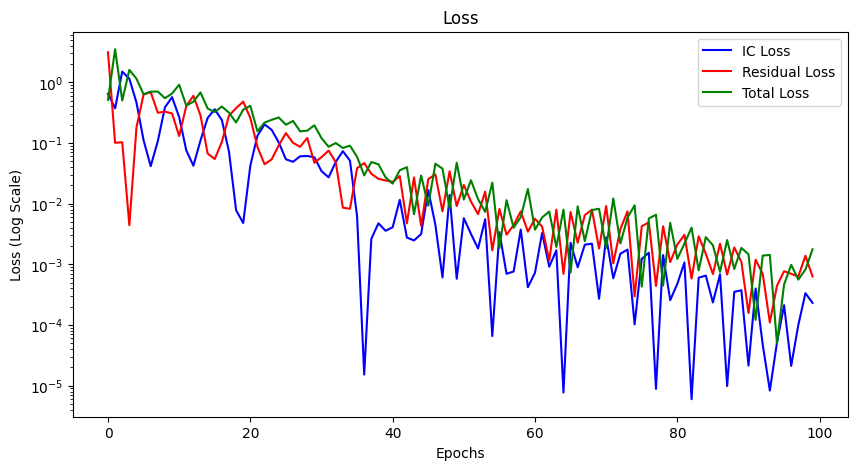

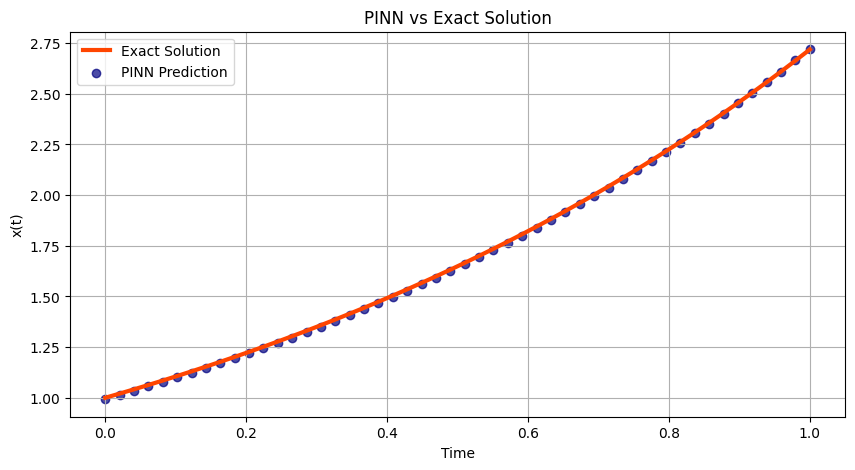

training time =  1.2588872909545898 s


In [ ]:
class PINN(nn.Module):
    def __init__(self, lambda_val, hidden_dim=16):
        super(PINN, self).__init__()
        self.lambda_val = lambda_val

        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t):
        return self.net(t)


def residual_loss(model, num_points=100):
    t_random = torch.rand(num_points, 1, device=device)
    t_random.requires_grad_(True)
    x_pred = model(t_random)
    x_t = torch.autograd.grad(x_pred, t_random, torch.ones_like(x_pred), create_graph=True)[0]
    residual = x_t - model.lambda_val * x_pred
    return torch.mean(residual ** 2)

def initial_condition_loss(model, x0, t0=torch.tensor([[0.0]], device=device)):
    x_pred = model(t0)
    return torch.mean((x_pred - x0) ** 2)

def total_loss(model, x0, num_points=100, weight_ic=1.0, weight_res=1.0):
    ic_loss = initial_condition_loss(model, x0)
    res_loss = residual_loss(model, 25)
    return weight_ic * ic_loss + weight_res * res_loss


def plot_results(model, lambda_val, x0, t_min=0, t_max=1, num_points=50):
    model.eval()

    t_values = torch.linspace(t_min, t_max, num_points).view(-1, 1).to(device)

    with torch.no_grad():
        predictions = model(t_values).cpu().numpy()

    exact_solution = x0 * np.exp(lambda_val * t_values.cpu().numpy())

    plt.figure(figsize=(10, 5))
    plt.plot(t_values.cpu().numpy(), exact_solution, label="Exact Solution", c='orangered', lw=3)
    plt.scatter(t_values.cpu().numpy(), predictions, label="PINN Prediction", c='navy', marker='o', alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("x(t)")
    plt.title("PINN vs Exact Solution")
    plt.legend()
    plt.grid(True)
    plt.show()


def train(model, x0, num_epochs=10000, num_info_after_iter=1000, lr=1e-3, wd=0.0, plot_loss=True, patience=2000):

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd) if wd else optim.Adam(model.parameters(), lr=lr)

    epoch_losses = {'residual_loss': [], 'ic_loss': [], 'total_loss': []}
    best_loss = float('inf')
    patience_counter = 0
    model.to(device)
    model.train()

    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        loss = total_loss(model, x0)
        loss.backward()
        optimizer.step()

        ic_loss = initial_condition_loss(model, x0).item()
        res_loss = residual_loss(model).item()

        epoch_losses['residual_loss'].append(res_loss)
        epoch_losses['ic_loss'].append(ic_loss)
        epoch_losses['total_loss'].append(loss.item())

        if not (epoch + 1) % num_info_after_iter:
            print(f"Epoch [{epoch+1}/{num_epochs}] | IC Loss: {ic_loss:.10f} | Residual Loss: {res_loss:.10f} | Total Loss: {loss.item():.10f}")

        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            torch.save(model.state_dict(), 'parameters.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in the last {patience} epochs.")
            break

    model.load_state_dict(torch.load('parameters.pth'))
    print(f"Stopping with best Total Loss: {best_loss:.10f}")

    if plot_loss:
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(epoch_losses['ic_loss'])), epoch_losses['ic_loss'], label="IC Loss", c='b')
        plt.plot(range(len(epoch_losses['residual_loss'])), epoch_losses['residual_loss'], label="Residual Loss", c='r')
        plt.plot(range(len(epoch_losses['total_loss'])), epoch_losses['total_loss'], label="Total Loss", c='g')
        plt.yscale('log')
        plt.xlabel("Epochs")
        plt.ylabel("Loss (Log Scale)")
        plt.title("Loss")
        plt.legend()
        plt.show()

    if plot_results:
        plot_results(model, lambda_val, x0.item())



lambda_val = torch.tensor(1.0, device=device)
x0 = torch.tensor([[1.0]], device=device)  # Initial condition x(0) = 1
pinn = PINN(lambda_val)
start = time()
train(pinn, x0, num_epochs=100, lr=0.1)
print('training time = ', time() - start, 's')

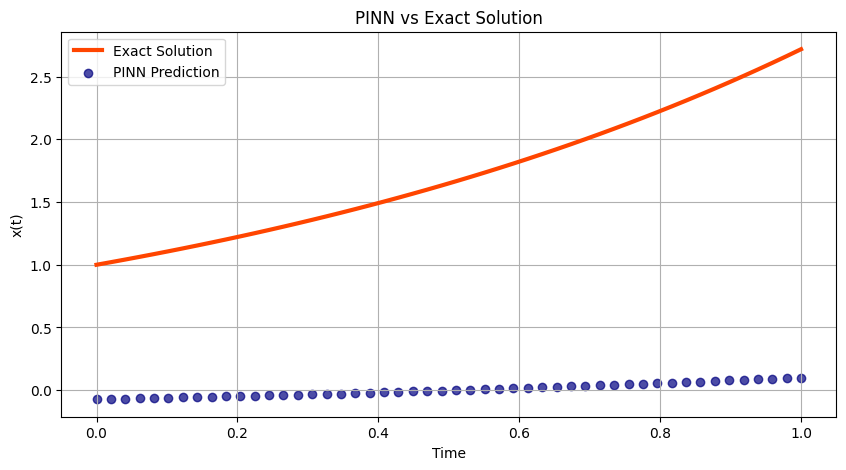

In [ ]:
pinn = PINN(lambda_val)
plot_results(pinn, lambda_val, x0.item())

In [ ]:
!python -V

Python 3.11.12
